In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [31]:
# Load dataset
df = pd.read_csv("data.csv", encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [32]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


(541909, 8)

**Step 1: Data Preprocessing**

In [33]:
# Drop missing CustomerIDs
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove negative/zero values
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("Data after cleaning:", df.shape)

Data after cleaning: (397884, 9)


**Step 2: RFM Calculation**


In [34]:
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'      # Monetary
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

print("\nRFM sample:\n", rfm.head())


RFM sample:
    CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


**Step 3: Quartile RFM Scoring**

In [35]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1).astype(int)

def rfm_category(score):
    if score >= 9: return "Champions"
    elif score >= 7: return "Loyal Customers"
    elif score >= 5: return "Potential Loyalist"
    else: return "At Risk"

rfm['Segment'] = rfm['RFM_Score'].apply(rfm_category)

print("\nRFM with segments:\n", rfm[['CustomerID','Recency','Frequency','Monetary','RFM_Score','Segment']].head())


RFM with segments:
    CustomerID  Recency  Frequency  Monetary  RFM_Score             Segment
0     12346.0      326          1  77183.60          6  Potential Loyalist
1     12347.0        2          7   4310.00         12           Champions
2     12348.0       75          4   1797.24          9           Champions
3     12349.0       19          1   1757.55          8     Loyal Customers
4     12350.0      310          1    334.40          4             At Risk


**Step 4: K-Means Clustering**

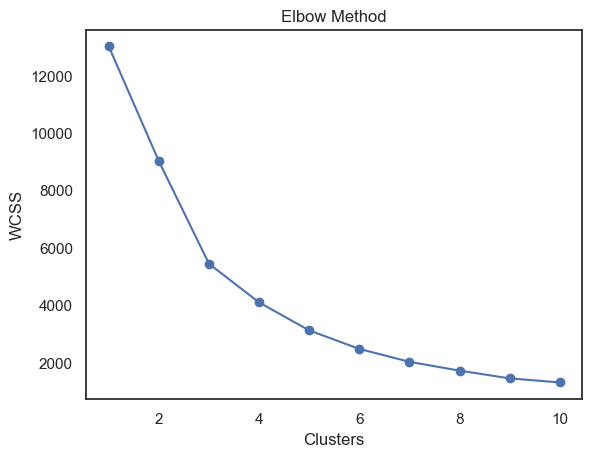


Cluster Summary:
    Cluster     Recency  Frequency       Monetary  Num_Customers
0        0   43.702685   3.682711    1359.049284           3054
1        1  248.075914   1.552015     480.617480           1067
2        2    7.384615  82.538462  127338.313846             13
3        3   15.500000  22.333333   12709.090490            204


In [36]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# Elbow Method
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("WCSS")
plt.show()

# Choose 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'CustomerID':'count'
}).rename(columns={'CustomerID':'Num_Customers'}).reset_index()

print("\nCluster Summary:\n", cluster_summary)

**Step 5: Profiling**

In [37]:
def map_cluster(row):
    if row['Cluster'] == 0: return "High Value Loyal"
    elif row['Cluster'] == 1: return "New Customers"
    elif row['Cluster'] == 2: return "At Risk"
    else: return "Low Value"

rfm['Cluster_Name'] = rfm.apply(map_cluster, axis=1)

print("\nCluster distribution:\n", rfm['Cluster_Name'].value_counts())


Cluster distribution:
 Cluster_Name
High Value Loyal    3054
New Customers       1067
Low Value            204
At Risk               13
Name: count, dtype: int64


**Step 6: Recommendations**

In [38]:
recommendations = {
    "High Value Loyal": "Reward loyalty with VIP offers, early access, and personalisation.",
    "New Customers": "Welcome campaigns, onboarding, and discounts.",
    "At Risk": "Re-engagement campaigns, win-back offers, and surveys.",
    "Low Value": "Cost-effective promotions, bundles, and upselling."
}

rfm['Recommendation'] = rfm['Cluster_Name'].map(recommendations)

**Step 7: Visualization**

**Comparison of Recency, Frequency, and Monetary Values by Cluster**

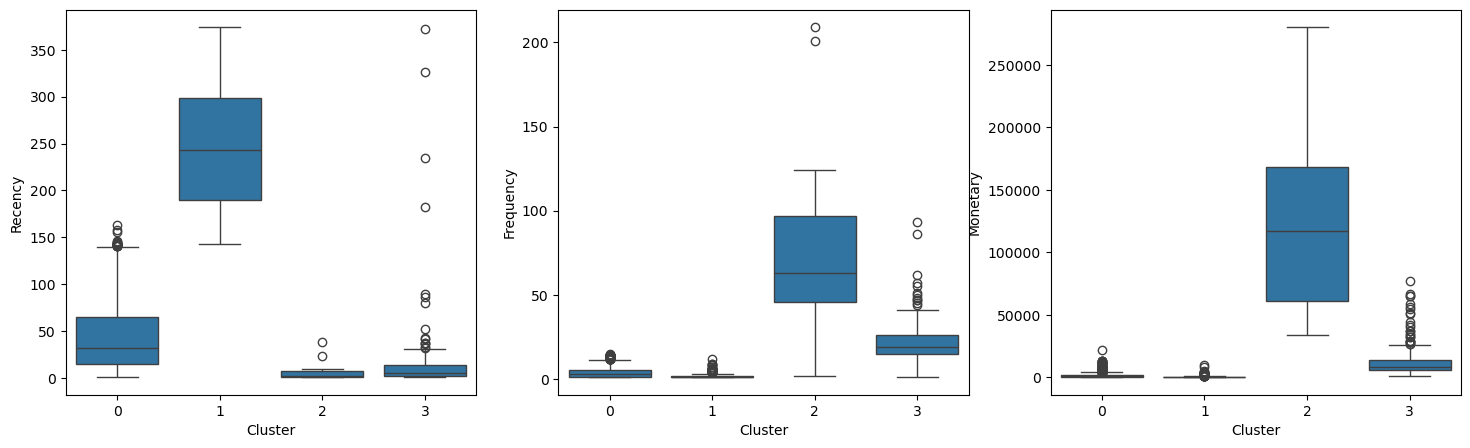

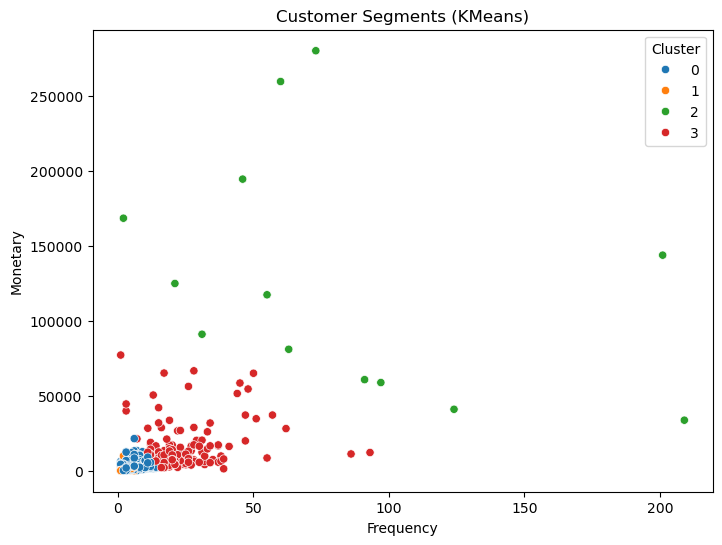

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0])
sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1])
sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2])
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='tab10')
plt.title("Customer Segments (KMeans)")
plt.show()

**Histogram of Recency, Frequency, and Monetary**

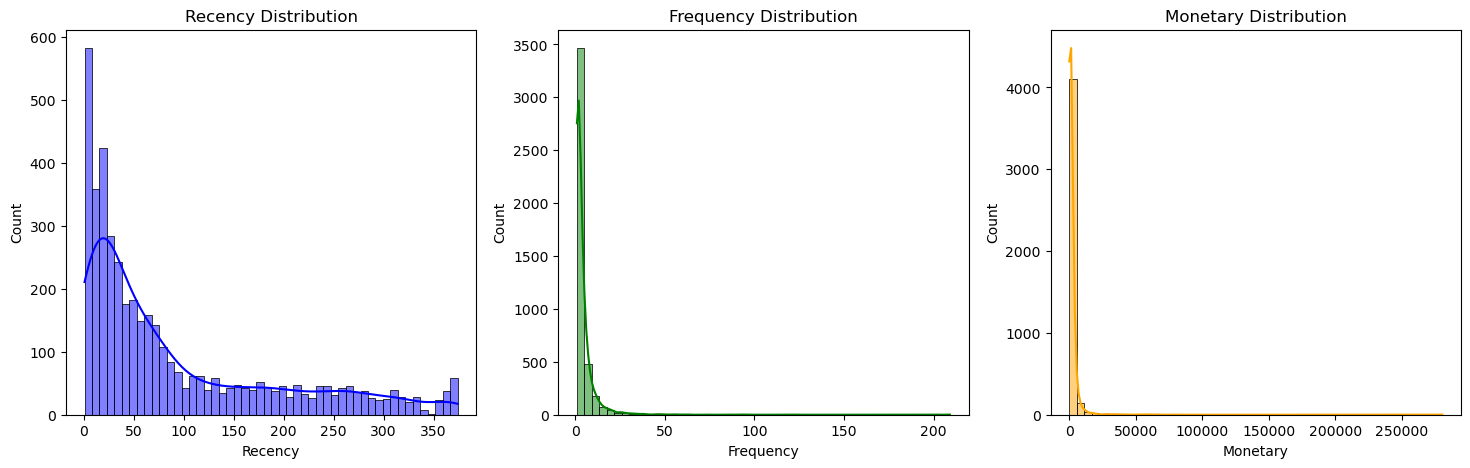

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(rfm['Recency'], bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Recency Distribution")
sns.histplot(rfm['Frequency'], bins=50, kde=True, ax=axes[1], color="green")
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm['Monetary'], bins=50, kde=True, ax=axes[2], color="orange")
axes[2].set_title("Monetary Distribution")
plt.show()

**Heatmap of RFM Quartile Segments**

/var/folders/wr/n4k8yvf101998p36zsz82rpw0000gn/T/ipykernel_20909/3187101169.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_pivot = rfm.pivot_table(index='F_Score', columns='R_Score', values='Monetary', aggfunc='mean')


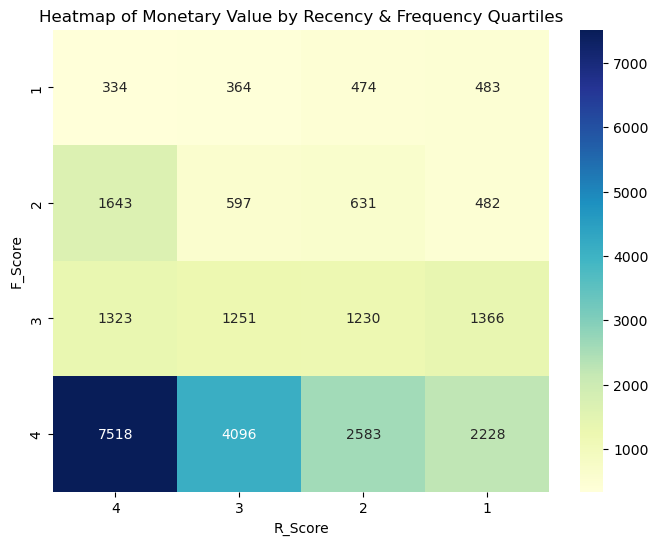

In [22]:
rfm_pivot = rfm.pivot_table(index='F_Score', columns='R_Score', values='Monetary', aggfunc='mean')
plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Heatmap of Monetary Value by Recency & Frequency Quartiles")
plt.show()

**Cluster Size Pie Chart**

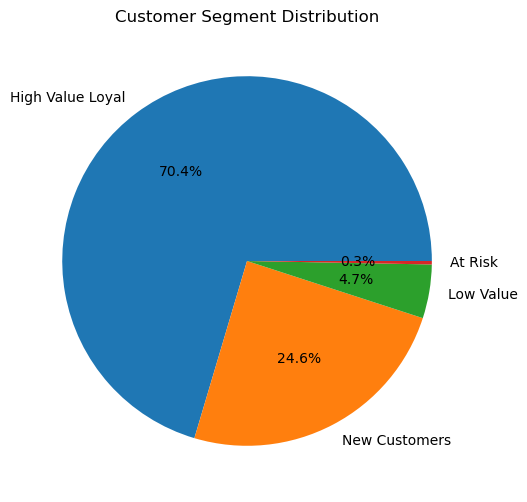

In [23]:
plt.figure(figsize=(6,6))
rfm['Cluster_Name'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette("tab10"))
plt.title("Customer Segment Distribution")
plt.ylabel("")
plt.show()

**Cluster Recency vs Frequency Bubble Chart**

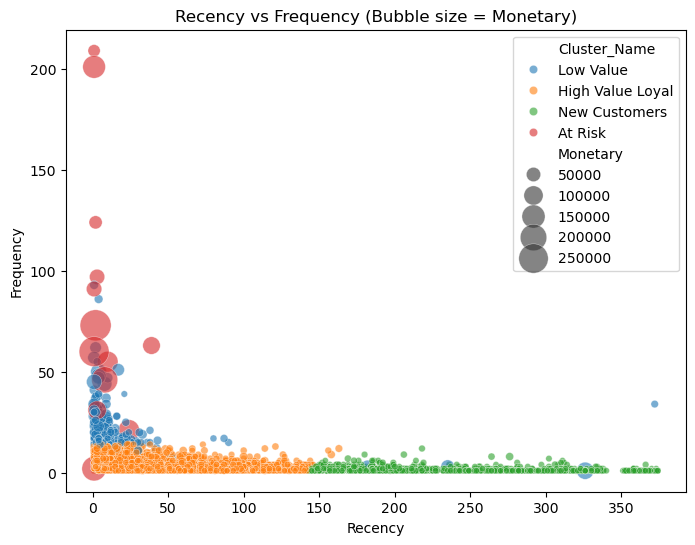

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm, x="Recency", y="Frequency", 
    hue="Cluster_Name", size="Monetary",
    sizes=(20, 500), alpha=0.6, palette="tab10"
)
plt.title("Recency vs Frequency (Bubble size = Monetary)")
plt.show()

**Step 8: Guideline Q&A**

In [29]:
print("\n--- 📊 Dataset Overview ---")
print(f"Dataset size: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Period: {df['InvoiceDate'].min().date()} → {df['InvoiceDate'].max().date()}")

print("\n--- 👥 Customer Analysis ---")
print(f"Unique customers: {df['CustomerID'].nunique():,}")
print("\nTop 5 customers by orders:\n")
print(df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head())
print("-"*60)

print("\n--- 📦 Product Analysis ---")
print(f"Average product price: ${df['UnitPrice'].mean():.2f}")
print("\nTop 10 most purchased products:\n")
print(df['Description'].value_counts().head(10))
print("\nTop 10 revenue-generating products:\n")
print(df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10))
print("-"*60)

print("\n--- ⏰ Time Analysis ---")
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour
print("\nOrders by day of week:\n")
print(df['DayOfWeek'].value_counts())
print("\nOrders by hour of day:\n")
print(df['Hour'].value_counts().sort_index())
print("-"*60)

print("\n--- 🌍 Geographical Analysis ---")
print("\nTop 5 countries by orders:\n")
print(df['Country'].value_counts().head(5))
print("-"*60)



--- 📊 Dataset Overview ---
Dataset size: 397,884 rows × 11 columns
Period: 2010-12-01 → 2011-12-09

--- 👥 Customer Analysis ---
Unique customers: 4,338

Top 5 customers by orders:

CustomerID
12748.0    209
14911.0    201
17841.0    124
13089.0     97
14606.0     93
Name: InvoiceNo, dtype: int64
------------------------------------------------------------

--- 📦 Product Analysis ---
Average product price: $3.12

Top 10 most purchased products:

Description
WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1723
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1396
LUNCH BAG RED RETROSPOT               1316
SET OF 3 CAKE TINS PANTRY DESIGN      1159
LUNCH BAG  BLACK SKULL.               1105
POSTAGE                               1099
PACK OF 72 RETROSPOT CAKE CASES       1068
Name: count, dtype: int64

Top 10 revenue-generating products:

Description
PAPER CRAFT , LITTLE BIRDIE     